In [1]:
# === Cell 1: Environment Setup ===

# Activate inline plots
%matplotlib inline

# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# FinRL imports
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot

# Stable Baselines3
from stable_baselines3 import TD3

# Make sure output directories exist
OUTPUT_DIR = "../daily_trade_FinRLBased_output"
MODEL_DIR = os.path.join(OUTPUT_DIR, "trained_models")
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")

for d in [OUTPUT_DIR, MODEL_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

print("✅ Environment setup complete.")


✅ Environment setup complete.


c:\Users\user\anaconda3\envs\finrl_etf_agent\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# === Cell 2: Download Data ===

import datetime

# Set target tickers and time range
TICKERS = ['XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLU', 'XLB',
    'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'PSQ', 'VNQ']

# Define date range
TODAY = datetime.datetime.today().strftime('%Y-%m-%d')
START_DATE = "2007-01-01"
SPLIT_DATE = (datetime.datetime.today() - datetime.timedelta(days=2*365)).strftime('%Y-%m-%d')

# Download data using FinRL’s YahooDownloader
df_raw = YahooDownloader(
    start_date=START_DATE,
    end_date=TODAY,
    ticker_list=TICKERS
).fetch_data()

# Log summary
print(f"✅ Downloaded data from {START_DATE} to {TODAY}")
print(f"📆 Split date (train/validation): {SPLIT_DATE}")
df_raw.head(32)


YF deprecation warning: set proxy via new config function: yf.set_proxy(proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (73713, 8)
✅ Downloaded data from 2007-01-01 to 2025-04-28
📆 Split date (train/validation): 2023-04-29


Price,date,close,high,low,open,volume,tic,day
0,2007-01-03,186.013458,251.520004,248.119995,248.800003,19200,DOG,2
1,2007-01-03,21.765913,27.000000,26.610001,26.790001,41800,ITA,2
2,2007-01-03,960.499329,1277.400024,1235.000000,1245.800049,14390,PSQ,2
3,2007-01-03,456.097321,502.079987,494.000000,495.440002,7525,SH,2
4,2007-01-03,16.800858,20.740000,20.083332,20.563334,509400,SOXX,2
5,2007-01-03,35.976498,77.709999,76.400002,77.339996,525700,VNQ,2
6,2007-01-03,23.324266,35.060001,34.439999,34.849998,3817800,XLB,2
7,2007-01-03,32.772747,58.389999,56.160000,58.310001,47465500,XLE,2
8,2007-01-03,20.873487,30.211210,29.764420,30.024370,9365079,XLF,2
9,2007-01-03,24.674246,35.560001,35.020000,35.130001,3095700,XLI,2


In [3]:
# === Cell 3: Feature Engineering ===

from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# Step 1: Clean and standardize raw data
df_raw = df_raw.rename(columns={"timestamp": "date"})
df_raw["date"] = pd.to_datetime(df_raw["date"]).dt.strftime("%Y-%m-%d")
df_raw = df_raw.drop_duplicates(subset=["date", "tic"])

# Step 2: Define technical indicators for day trading
INDICATORS = [
    'macd',       # Momentum
    'rsi_14',     # Overbought/oversold detection
    'cci_14',     # Quick trend momentum
    'atr',        # Volatility
    'adx',        # Trend strength
    'kdjk',       # Stochastic oscillator - %K
    'kdjd',       # Stochastic oscillator - %D
    'wr_10'       # Williams %R
]

# Step 3: Run feature engineering
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_turbulence=True,
    user_defined_feature=False
)

df_processed = fe.preprocess_data(df_raw)
df_processed = df_processed.fillna(0).replace(np.inf, 0)
df_processed = df_processed.sort_values(["date", "tic"]).reset_index(drop=True)

print(f"✅ Feature engineering complete. Processed shape: {df_processed.shape}")
df_processed.head(32)


Successfully added technical indicators
Successfully added turbulence index
✅ Feature engineering complete. Processed shape: (69120, 17)


,date,close,high,low,open,volume,tic,day,macd,rsi_14,cci_14,atr,adx,kdjk,kdjd,wr_10,turbulence
0,2007-01-03,186.013458,251.520004,248.119995,248.800003,19200,DOG,2,0.000000,100.0,66.666667,65.506546,100.0,-575.552643,-158.517548,-1926.657930,0.0
1,2007-01-03,21.765913,27.000000,26.610001,26.790001,41800,ITA,2,0.000000,100.0,66.666667,5.234087,100.0,-380.691896,-93.563965,-1342.075688,0.0
2,2007-01-03,960.499329,1277.400024,1235.000000,1245.800049,14390,PSQ,2,0.000000,100.0,66.666667,316.900696,100.0,-182.468957,-27.489652,-747.406871,0.0
3,2007-01-03,456.097321,502.079987,494.000000,495.440002,7525,SH,2,0.000000,100.0,66.666667,45.982666,100.0,-123.031116,-7.677039,-569.093347,0.0
4,2007-01-03,16.800858,20.740000,20.083332,20.563334,509400,SOXX,2,0.000000,100.0,66.666667,3.939142,100.0,-133.289474,-11.096491,-599.868422,0.0
5,2007-01-03,35.976498,77.709999,76.400002,77.339996,525700,VNQ,2,0.000000,100.0,66.666667,41.733501,100.0,-995.256468,-298.418823,-3185.769405,0.0
6,2007-01-03,23.324266,35.060001,34.439999,34.849998,3817800,XLB,2,0.000000,100.0,66.666667,11.735735,100.0,-564.284030,-154.761343,-1892.852089,0.0
7,2007-01-03,32.772747,58.389999,56.160000,58.310001,47465500,XLE,2,0.000000,100.0,66.666667,25.617252,100.0,-316.251982,-72.083994,-1148.755947,0.0
8,2007-01-03,20.873487,30.211210,29.764420,30.024370,9365079,XLF,2,0.000000,100.0,66.666667,9.337723,100.0,-629.984874,-176.661625,-2089.954621,0.0
9,2007-01-03,24.674246,35.560001,35.020000,35.130001,3095700,XLI,2,0.000000,100.0,66.666667,10.885756,100.0,-605.292413,-168.430804,-2015.877238,0.0


In [4]:
# === Cell 4: Environment Configuration ===

# Count number of unique tickers
stock_dim = len(df_processed["tic"].unique())
state_space = 1 + 2 * stock_dim + len(INDICATORS) * stock_dim

# Print state space details
print(f"✅ Stock dimension: {stock_dim}")
print(f"✅ State space size: {state_space}")

# Define environment kwargs
buy_cost_list = [0.001] * stock_dim
sell_cost_list = [0.001] * stock_dim

env_kwargs = {
    "hmax": 100,
    "initial_amount": 100000,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dim,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dim,
    "reward_scaling": 1e-4,
    "print_verbosity": 0,
    "turbulence_threshold": None,
    "make_plots": False,
    "risk_indicator_col": "turbulence",
    "mode": "train",
    "model_name": "td3",
    "iteration": 0,
    "initial": True,
    "num_stock_shares": [0] * stock_dim,
    "day": 0,
    "previous_state": [],
}


print("✅ Environment kwargs ready.")


✅ Stock dimension: 15
✅ State space size: 151
✅ Environment kwargs ready.


In [5]:
# === Cell 5: Patch Env for Gymnasium and Stable Training ===
from finrl.meta.env_stock_trading import env_stocktrading
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

# Backup originals once
if not hasattr(StockTradingEnv, "__original_init__"):
    StockTradingEnv.__original_init__ = StockTradingEnv.__init__
    StockTradingEnv.__original_step__ = StockTradingEnv.step
    StockTradingEnv.__original_update_state__ = StockTradingEnv._update_state
    StockTradingEnv.__original_initiate_state__ = StockTradingEnv._initiate_state

# Patch __init__ to ensure reward_memory exists
def patched_init(self, *args, **kwargs):
    StockTradingEnv.__original_init__(self, *args, **kwargs)
    if not hasattr(self, "reward_memory"):
        self.reward_memory = []

# Patch _initiate_state for multi-stock
def patched_initiate_state(self):
    current_date = self.df.loc[self.day, "date"]
    self.data = self.df[self.df["date"] == current_date].sort_values("tic")
    state = (
        [self.initial_amount]
        + self.data["close"].tolist()
        + self.num_stock_shares
        + sum((self.data[tech].tolist() for tech in self.tech_indicator_list), [])
    )
    return state

# Patch _update_state to avoid .values on float
def patched_update_state(self):
    current_date = self.df.loc[self.day, "date"]
    self.data = self.df[self.df["date"] == current_date].sort_values("tic")
    state = (
        [self.state[0]]
        + self.data["close"].tolist()
        + list(self.state[self.stock_dim + 1 : self.stock_dim * 2 + 1])
        + sum((self.data[tech].tolist() for tech in self.tech_indicator_list), [])
    )
    return state

# Patch step to return 5 values
def patched_step(self, actions):
    obs, reward, terminated, truncated, info = StockTradingEnv.__original_step__(self, actions)
    return obs, reward, terminated, truncated, info

# Apply patches
StockTradingEnv.__init__ = patched_init
StockTradingEnv._initiate_state = patched_initiate_state
StockTradingEnv._update_state = patched_update_state
StockTradingEnv.step = patched_step

# Rebuild env
train_env = StockTradingEnv(df=df_processed, **env_kwargs)
print("✅ Rebuilt and fully patched StockTradingEnv.")


✅ Rebuilt and fully patched StockTradingEnv.


In [ ]:
# === Cell 6: Train & Validate TD3 Model (with custom logging) ===

from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import os
import numpy as np

# Split the processed dataset
df_train = df_processed[df_processed['date'] < SPLIT_DATE]
df_val = df_processed[df_processed['date'] >= SPLIT_DATE]

print(f"✅ Training set: {df_train['date'].min()} to {df_train['date'].max()} ({len(df_train)} rows)")
print(f"✅ Validation set: {df_val['date'].min()} to {df_val['date'].max()} ({len(df_val)} rows)")

# Create training environment
train_env = DummyVecEnv([lambda: StockTradingEnv(df=df_train.copy(), **env_kwargs)])

# Define action noise
n_actions = env_kwargs["action_space"]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Define model
model = TD3(
    "MlpPolicy",
    train_env,
    action_noise=action_noise,
    verbose=1,
    tensorboard_log=os.path.join(OUTPUT_DIR, "tensorboard"),
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# Train model
total_timesteps = 50_000
model_name = "td3_model"
model_path = os.path.join(MODEL_DIR, f"{model_name}.zip")

print("🚀 Starting TD3 training...")
model.learn(total_timesteps=total_timesteps)
print("✅ Training complete.")
model.save(model_path)
print(f"💾 Model saved to: {model_path}")

# ==== Validation Phase ====
print("🧪 TD3 Validation Phase")

# Reset env_kwargs fields that should be reset before validation
env_kwargs["initial"] = True
env_kwargs["day"] = 0
env_kwargs["previous_state"] = []
env_kwargs["model_name"] = "td3"
env_kwargs["mode"] = "test"
env_kwargs["iteration"] = 0

df_val_reset = df_val.copy()

val_env = DummyVecEnv([lambda: StockTradingEnv(df=df_val_reset, **env_kwargs)])

obs = val_env.reset()
dates = sorted(df_val['date'].unique())
portfolio_values = []
val_rewards = []

for step in range(len(dates)):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = val_env.step(action)
    val_rewards.append(reward[0])

    # Retrieve current portfolio value from env
    current_value = val_env.envs[0].state[0]
    portfolio_values.append(current_value)

    if done[0]:
        break

# Create portfolio DataFrame for backtesting analysis
portfolio_df = pd.DataFrame({
    "date": dates[:len(portfolio_values)],
    "account_value": portfolio_values
})

from finrl.plot import backtest_stats
print("\n📊 ===== Validation Backtest Results =====")
bt_result = backtest_stats(portfolio_df)
print(bt_result)


✅ Training set: 2007-01-03 to 2023-04-28 (61635 rows)
✅ Validation set: 2023-05-01 to 2025-04-25 (7485 rows)
Using cuda device
🚀 Starting TD3 training...
Logging to ../daily_trade_FinRLBased_output\tensorboard\TD3_20
✅ Training complete.
💾 Model saved to: ../daily_trade_FinRLBased_output\trained_models\td3_model.zip
🧪 TD3 Validation Phase
📊 ===== Validation Summary =====
Date Range: 2023-05-01 → 2025-04-25
Steps: 498
Mean Validation Reward: 0.001812


📊 Running full backtest from entire dataset...


[*********************100%***********************]  1 of 1 completed

💾 Logs saved to: ../daily_trade_FinRLBased_output\results
📈 Fetching SPY benchmark data...
Shape of DataFrame:  (307, 8)


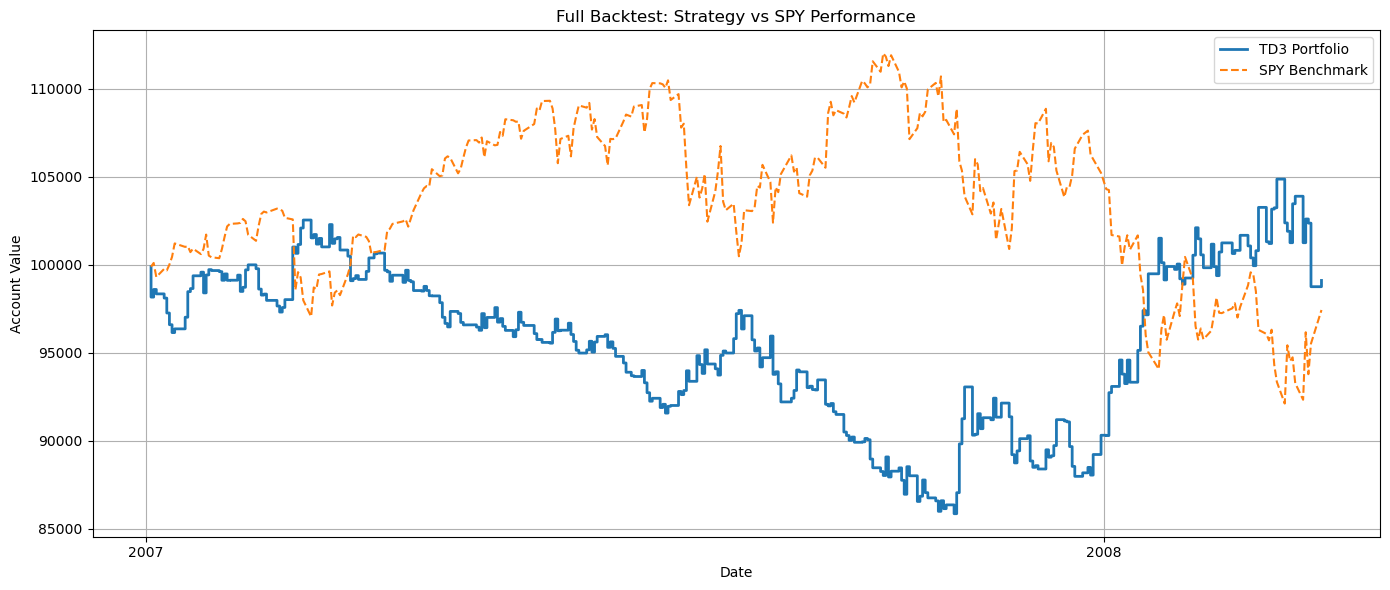

📊 Performance Metrics (Strategy):
Annual return         -0.000430
Cumulative returns    -0.007834
Annual volatility      0.037704
Sharpe ratio           0.007418
Calmar ratio          -0.002643
Stability              0.076652
Max drawdown          -0.162751
Omega ratio            1.004873
Sortino ratio          0.010935
Skew                        NaN
Kurtosis                    NaN
Tail ratio                  NaN
Daily value at risk   -0.004749
dtype: float64


c:\Users\user\anaconda3\envs\finrl_etf_agent\lib\site-packages\empyrical\stats.py:1424: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.percentile(returns, 95)) / np.abs(np.percentile(returns, 5))


,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
0,-0.00043,-0.007834,0.037704,0.007418,-0.002643,0.076652,-0.162751,1.004873,0.010935,NaN,NaN,NaN,-0.004749


In [ ]:


# === Cell 7: Full Backtest and Compare with SPY ===
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from finrl.plot import backtest_stats
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

# 🟩 Use the full df_processed (2007–TODAY) for backtest
print("📊 Running full backtest from entire dataset...")
df_backtest = df_processed.copy().reset_index(drop=True)
back_env = DummyVecEnv([lambda: StockTradingEnv(df=df_backtest, **env_kwargs)])

obs = back_env.reset()
account_values = []
action_records = []
ticker_order = df_backtest['tic'].unique().tolist()

for i in range(len(df_backtest['date'].unique()) - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = back_env.step(action)

    total_asset = back_env.envs[0].state[0] + sum(
        np.array(back_env.envs[0].state[1:1+stock_dim]) *
        np.array(back_env.envs[0].state[1+stock_dim:1+stock_dim*2])
    )

    account_values.append({
        "date": pd.to_datetime(df_backtest.loc[i, "date"]),
        "account_value": total_asset
    })

    action_records.append({
        "date": pd.to_datetime(df_backtest.loc[i, "date"]),
        **{ticker: round(a, 3) for ticker, a in zip(ticker_order, action.tolist())}
    })

    if done[0]:
        break

# Save logs to CSV
import os
os.makedirs(RESULTS_DIR, exist_ok=True)
df_account_value = pd.DataFrame(account_values)
df_account_value["date"] = pd.to_datetime(df_account_value["date"])
df_account_value["daily_return"] = df_account_value["account_value"].pct_change()
df_account_value["cumulative_return"] = (1 + df_account_value["daily_return"]).cumprod()

csv_path = os.path.join(RESULTS_DIR, "td3_backtest_log.csv")
df_account_value.to_csv(csv_path, index=False)
print(f"💾 Backtest log saved to: {csv_path}")

# Save actions to CSV
df_actions = pd.DataFrame(action_records)
action_path = os.path.join(RESULTS_DIR, "td3_action_log.csv")
df_actions.to_csv(action_path, index=False)
print(f"💾 Action log saved to: {action_path}")

# 2. Get SPY baseline for same period
print("📈 Fetching SPY benchmark data...")
df_spy = YahooDownloader(
    start_date=str(df_account_value['date'].iloc[0].date()),
    end_date=str(df_account_value['date'].iloc[-1].date()),
    ticker_list=["SPY"]
).fetch_data()

df_spy_daily = df_spy[df_spy['tic'] == 'SPY'].copy()
df_spy_daily["date"] = pd.to_datetime(df_spy_daily["date"])
df_spy_daily = df_spy_daily.sort_values("date")
df_spy_daily["dji"] = df_spy_daily["close"] / df_spy_daily["close"].iloc[0] * df_account_value["account_value"].iloc[0]

# 3. Merge and plot
df_compare = pd.merge(
    df_account_value[["date", "account_value"]],
    df_spy_daily[["date", "dji"]],
    on="date",
    how="inner"
)
df_compare.set_index("date", inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(df_compare["account_value"], label="TD3 Portfolio", linewidth=2)
plt.plot(df_compare["dji"], label="SPY Benchmark", linestyle="--")

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.title("Full Backtest: Strategy vs SPY Performance")
plt.xlabel("Date")
plt.ylabel("Account Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Print strategy metrics
print("📊 Performance Metrics (Strategy):")
strategy_stats = backtest_stats(account_value=df_account_value)
strategy_stats = pd.DataFrame(strategy_stats)
display(strategy_stats.T)
